Accuracy: 0.9824561403508771
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion Matrix:
 [[41  2]
 [ 0 71]]


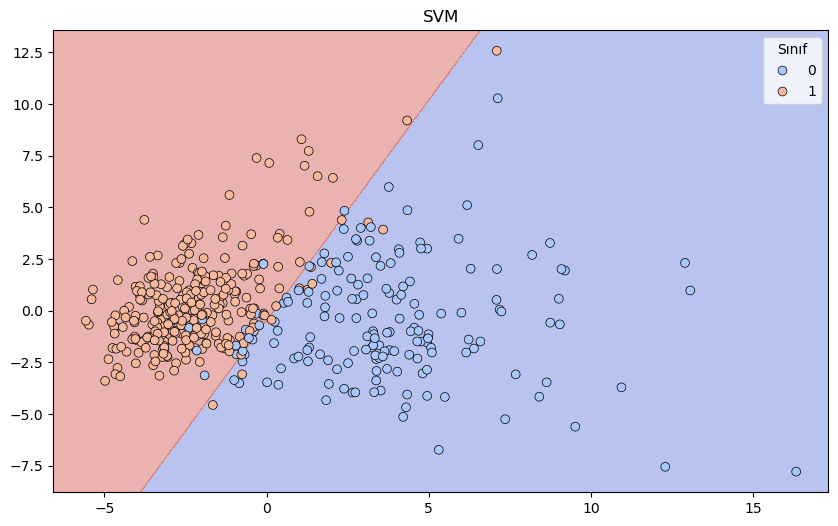

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Veri Seti
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

# Veriyi Ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA ile veri boyutunu 2 bileşene indiriyoruz
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Veri Setini Eğitim ve Test Olarak Bölme
# Veri seti %80 eğitim, %20 test olacak şekilde bölünüdü
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)


# En İyi Modelin Tahminleri
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


# Performans Metrikleri
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.decision_function(X_test))


# Sonuçları Yazdırma
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# PCA Kullanarak Eğitim ve Test Setleri Oluşturma
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# PCA ile Model Eğitimi
model_pca = SVC(kernel=grid.best_params_['kernel'], C=grid.best_params_['C'],
                gamma=grid.best_params_['gamma'], probability=True)
model_pca.fit(X_train_pca, y_train_pca)

# Karar Sınırını Görselleştirme
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Görselleştirme
plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train_pca, palette='coolwarm', edgecolor='k',s=40)
plt.title("SVM")
plt.legend(title='Sınıf')
plt.show()
